In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Exact solution for error analysis
def exact_solution(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Finite Difference Method
def finite_difference_solver(N):
    """
    N: Number of grid sizes eg: 5x5, 10x10, 20x20
    """
    h = 1 / (N - 1)
    u = np.zeros((N, N)) 
    x_lower_bound = 0
    x_upper_bound = 1
    y_lower_bound = 0
    y_upper_bound = 1

    # Discretize f(x, y) = sin(pi*x) * sin(pi*y) on the grid
    x = np.linspace(x_lower_bound, x_upper_bound, N)
    y = np.linspace(y_lower_bound, y_upper_bound, N)
    X, Y = np.meshgrid(x,y)
    F = np.sin(np.pi * X) * np.sin(np.pi * Y)

    # Iterative solver using Jacobi
    tol = 1e-5
    for _ in range(10000):  # Max iterations
        u_old = u.copy()
        # Update only interior points
        for i in range(1, N-1):
            for j in range(1, N-1):
                u[i, j] = 0.25 * (u[i+1, j] + u[i-1, j] + u[i, j+1] + u[i, j-1] - h**2 * F[i, j])
        # Convergence check
        if np.max(np.abs(u - u_old)) < tol:
            break
    return u


In [16]:

# PINN neural network
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        layer_list = []
        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                layer_list.append(nn.Tanh())  # Activation for hidden layers
        self.network = nn.Sequential(*layer_list)

    def forward(self, x):
        return self.network(x)
    
# PINN Solver Function
def pinn_solver(N, layers):
    # Create grid points
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    xx, yy = np.meshgrid(x, y)
    grid_points = np.stack((xx.flatten(), yy.flatten()), axis=-1)
    grid_points = torch.tensor(grid_points, dtype=torch.float32, requires_grad=True)

    # Instantiate neural network and optimizer
    model = PINN(layers)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(10000):
        optimizer.zero_grad()

        # Compute predicted u and its Laplacian (second derivatives)
        u_pred = model(grid_points).reshape(N, N)
        u_x = torch.autograd.grad(u_pred.sum(), grid_points, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x[:, 0].sum(), grid_points, create_graph=True)[0]
        u_yy = torch.autograd.grad(u_x[:, 1].sum(), grid_points, create_graph=True)[0]
        laplace_u = u_xx[:, 0] + u_yy[:, 1]

        # Loss: (Laplacian residual) + (boundary condition)
        f = torch.sin(np.pi * grid_points[:, 0]) * torch.sin(np.pi * grid_points[:, 1])
        interior_loss = torch.mean((laplace_u - f) ** 2)

        # Reshape boundary indices mask to match u_pred shape
        boundary_indices = (xx == 0) | (xx == 1) | (yy == 0) | (yy == 1)
        boundary_loss = torch.mean(u_pred[boundary_indices] ** 2)
        
        loss = interior_loss + boundary_loss

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Check for convergence
        if loss.item() < 1e-5:
            break
    return u_pred.detach().numpy()



# Experiment: Compare FDM and PINN with grid sizes and architectures
for N in [5, 10, 20]:
    fdm_solution = finite_difference_solver(N)
    pinn_solution = pinn_solver(N, [2, 5, 5, 1])
    exact = exact_solution(np.linspace(0, 1, N), np.linspace(0, 1, N))
    
    # Calculate error for FDM and PINN
    fdm_error = np.abs(fdm_solution - exact).mean()
    pinn_error = np.abs(pinn_solution - exact).mean()
    
    print(f"Grid size: {N}x{N} - FDM Error: {fdm_error:.5f}, PINN Error: {pinn_error:.5f}")


Grid size: 5x5 - FDM Error: 0.01045, PINN Error: 0.01084
Grid size: 10x10 - FDM Error: 0.01047, PINN Error: 0.01062
Grid size: 20x20 - FDM Error: 0.01044, PINN Error: 0.01049


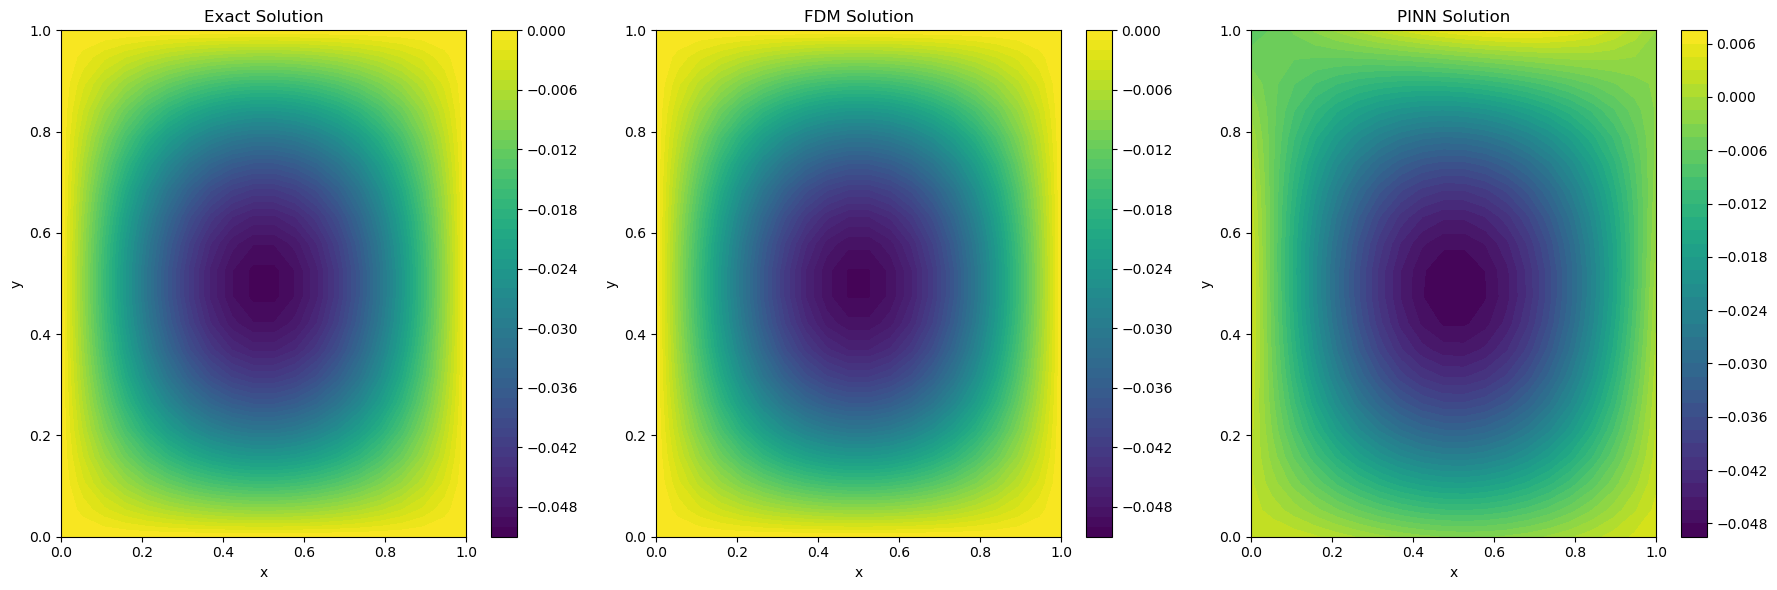

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the solutions
def plot_solutions(exact, fdm_solution, pinn_solution, N):
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Exact Solution
    ax = axes[0]
    cp = ax.contourf(X, Y, exact, levels=50, cmap='viridis')
    fig.colorbar(cp, ax=ax)
    ax.set_title('Exact Solution')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # FDM Solution
    ax = axes[1]
    cp = ax.contourf(X, Y, fdm_solution, levels=50, cmap='viridis')
    fig.colorbar(cp, ax=ax)
    ax.set_title('FDM Solution')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # PINN Solution
    ax = axes[2]
    cp = ax.contourf(X, Y, pinn_solution, levels=50, cmap='viridis')
    fig.colorbar(cp, ax=ax)
    ax.set_title('PINN Solution')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    plt.tight_layout()
    plt.show()

# Example usage
N = 20  # Grid size
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)
exact = exact_solution(X, Y)
fdm_solution = finite_difference_solver(N)
pinn_solution = pinn_solver(N, [2, 5, 5, 1])
plot_solutions(exact, fdm_solution, pinn_solution, N)


In [10]:
# # Number of grid points
# N = 5
# numerical_solution, X, Y = finite_difference_solver(N)
# exact = exact_solution(X, Y)


# # Compute the error
# error = np.abs(numerical_solution - exact)

# print("Numerical Solution:\n", numerical_solution)
# print("Exact Solution:\n", exact)
# print("Error:\n", error)

# # Error plot
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.contourf(X, Y, error, levels=50, cmap='viridis')
# plt.colorbar(label='Error')
# plt.title('Error between Numerical and Exact Solution')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.show()


In [19]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam, LBFGS
import time

class PINN(nn.Module):
    def __init__(self, hidden_layers):
        super().__init__()
        layers = []
        input_dim = 2  # x and y coordinates
        
        # Build the network based on specified architecture
        for h in hidden_layers:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.Tanh())
            input_dim = h
            
        layers.append(nn.Linear(input_dim, 1))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x, y):
        xy = torch.cat([x, y], dim=1)
        return self.network(xy)
    
    def compute_loss(self, x_interior, y_interior, x_boundary, y_boundary):
        # Interior points
        x_interior.requires_grad_(True)
        y_interior.requires_grad_(True)
        
        u = self.forward(x_interior, y_interior)
        
        # Compute derivatives for Laplacian
        du_dx = torch.autograd.grad(u, x_interior, grad_outputs=torch.ones_like(u),
                                  create_graph=True)[0]
        du_dy = torch.autograd.grad(u, y_interior, grad_outputs=torch.ones_like(u),
                                  create_graph=True)[0]
        
        d2u_dx2 = torch.autograd.grad(du_dx, x_interior, grad_outputs=torch.ones_like(du_dx),
                                    create_graph=True)[0]
        d2u_dy2 = torch.autograd.grad(du_dy, y_interior, grad_outputs=torch.ones_like(du_dy),
                                    create_graph=True)[0]
        
        # PDE residual: ∇²u = sin(πx)sin(πy)
        laplacian = d2u_dx2 + d2u_dy2
        f = torch.sin(np.pi * x_interior) * torch.sin(np.pi * y_interior)
        pde_loss = torch.mean((laplacian - f) ** 2)
        
        # Boundary conditions
        u_boundary = self.forward(x_boundary, y_boundary)
        bc_loss = torch.mean(u_boundary ** 2)  # Should be 0 at boundaries
        
        total_loss = pde_loss + bc_loss
        return total_loss, pde_loss, bc_loss

def generate_points(n_points):
    # Interior points
    x = torch.linspace(0, 1, n_points)
    y = torch.linspace(0, 1, n_points)
    x_mesh, y_mesh = torch.meshgrid(x, y, indexing='ij')
    x_interior = x_mesh.reshape(-1, 1)
    y_interior = y_mesh.reshape(-1, 1)
    
    # Boundary points
    x_boundary = torch.cat([torch.zeros(n_points), torch.ones(n_points),
                          torch.linspace(0, 1, n_points), torch.linspace(0, 1, n_points)])
    y_boundary = torch.cat([torch.linspace(0, 1, n_points), torch.linspace(0, 1, n_points),
                          torch.zeros(n_points), torch.ones(n_points)])
    x_boundary = x_boundary.reshape(-1, 1)
    y_boundary = y_boundary.reshape(-1, 1)
    
    return x_interior, y_interior, x_boundary, y_boundary

def exact_solution(x, y):
    return -1/(2*np.pi**2) * torch.sin(np.pi*x) * torch.sin(np.pi*y)

def train_pinn(model, x_interior, y_interior, x_boundary, y_boundary, optimizer, max_epochs=1000):
    losses = []
    best_loss = float('inf')
    patience = 50
    patience_counter = 0
    
    for epoch in range(max_epochs):
        optimizer.zero_grad()
        loss, pde_loss, bc_loss = model.compute_loss(x_interior, y_interior, x_boundary, y_boundary)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
            
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}, PDE Loss = {pde_loss.item():.6f}, BC Loss = {bc_loss.item():.6f}")
    
    return losses

def evaluate_solution(model, grid_size):
    x = torch.linspace(0, 1, grid_size).reshape(-1, 1)
    y = torch.linspace(0, 1, grid_size).reshape(-1, 1)
    x_mesh, y_mesh = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
    
    x_eval = x_mesh.reshape(-1, 1)
    y_eval = y_mesh.reshape(-1, 1)
    
    with torch.no_grad():
        u_pred = model(x_eval, y_eval)
        u_exact = exact_solution(x_eval, y_eval)
    
    mse = torch.mean((u_pred - u_exact)**2)
    return mse.item(), u_pred.reshape(grid_size, grid_size), u_exact.reshape(grid_size, grid_size)

def main():
    # Grid sizes to test
    grid_sizes = [5, 10, 20]
    # Network architectures to test
    architectures = [
        [2, 3, 3, 1],
        [2, 5, 5, 1],
        [2, 10, 10, 1]
    ]
    
    results = {}
    
    for n_points in grid_sizes:
        print(f"\nTraining with grid size {n_points}x{n_points}")
        x_interior, y_interior, x_boundary, y_boundary = generate_points(n_points)
        
        for arch in architectures:
            hidden_layers = arch[1:-1]
            model = PINN(hidden_layers)
            
            # Train with Adam
            optimizer = Adam(model.parameters(), lr=0.001)
            start_time = time.time()
            losses = train_pinn(model, x_interior, y_interior, x_boundary, y_boundary, optimizer)
            training_time = time.time() - start_time
            
            # Evaluate
            mse, u_pred, u_exact = evaluate_solution(model, 50)  # Use 50x50 grid for evaluation
            
            arch_name = '-'.join(map(str, arch))
            results[f"grid_{n_points}_arch_{arch_name}"] = {
                'mse': mse,
                'training_time': training_time,
                'final_loss': losses[-1]
            }
            
            print(f"Architecture {arch_name}:")
            print(f"MSE: {mse:.6f}")
            print(f"Training time: {training_time:.2f}s")
    
    return results

if __name__ == "__main__":
    results = main()
    print("\nFinal Results:")
    for key, value in results.items():
        print(f"\n{key}:")
        print(f"MSE: {value['mse']:.6e}")
        print(f"Training time: {value['training_time']:.2f}s")
        print(f"Final loss: {value['final_loss']:.6e}")


Training with grid size 5x5
Epoch 0: Loss = 0.166312, PDE Loss = 0.140428, BC Loss = 0.025884
Epoch 100: Loss = 0.106865, PDE Loss = 0.104844, BC Loss = 0.002021
Epoch 200: Loss = 0.090577, PDE Loss = 0.087087, BC Loss = 0.003490
Epoch 300: Loss = 0.086550, PDE Loss = 0.084828, BC Loss = 0.001722
Epoch 400: Loss = 0.083995, PDE Loss = 0.083132, BC Loss = 0.000862
Epoch 500: Loss = 0.081792, PDE Loss = 0.081114, BC Loss = 0.000679
Epoch 600: Loss = 0.077389, PDE Loss = 0.076755, BC Loss = 0.000634
Epoch 700: Loss = 0.071939, PDE Loss = 0.071370, BC Loss = 0.000569
Epoch 800: Loss = 0.069216, PDE Loss = 0.068733, BC Loss = 0.000482
Epoch 900: Loss = 0.068135, PDE Loss = 0.067718, BC Loss = 0.000416
Architecture 2-3-3-1:
MSE: 0.000180
Training time: 2.72s
Epoch 0: Loss = 0.220503, PDE Loss = 0.168421, BC Loss = 0.052082
Epoch 100: Loss = 0.116674, PDE Loss = 0.112236, BC Loss = 0.004438
Epoch 200: Loss = 0.089769, PDE Loss = 0.082676, BC Loss = 0.007093
Epoch 300: Loss = 0.077605, PDE Lo


Grid size: 5x5
Solving with FDM...
FDM converged after 18 iterations

Training PINN with architecture [2, 3, 3, 1]...
Epoch 0: Loss = 0.166023, PDE Loss = 0.160285, BC Loss = 0.005737
Epoch 100: Loss = 0.153468, PDE Loss = 0.153323, BC Loss = 0.000145
Epoch 200: Loss = 0.119488, PDE Loss = 0.116401, BC Loss = 0.003087
Epoch 300: Loss = 0.097898, PDE Loss = 0.089453, BC Loss = 0.008444
Epoch 400: Loss = 0.086845, PDE Loss = 0.081233, BC Loss = 0.005612
Epoch 500: Loss = 0.059206, PDE Loss = 0.058721, BC Loss = 0.000485
Epoch 600: Loss = 0.047501, PDE Loss = 0.047096, BC Loss = 0.000405
Epoch 700: Loss = 0.036156, PDE Loss = 0.035392, BC Loss = 0.000763
Epoch 800: Loss = 0.019240, PDE Loss = 0.016591, BC Loss = 0.002649
Epoch 900: Loss = 0.012862, PDE Loss = 0.009844, BC Loss = 0.003018
FDM converged after 18 iterations


C:\Users\johna\AppData\Local\Temp\ipykernel_16420\3789882139.py:146: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


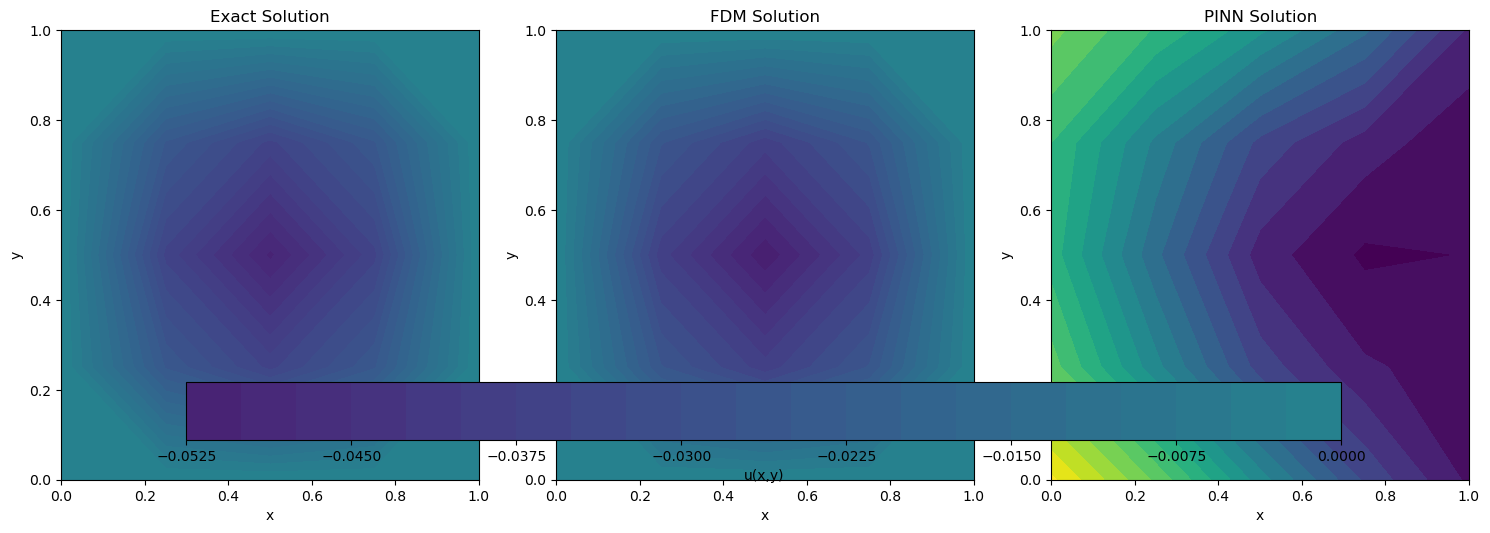


Error Metrics:
FDM MSE: 1.15e-06
PINN MSE: 1.57e-03

Training PINN with architecture [2, 5, 5, 1]...
Epoch 0: Loss = 0.138175, PDE Loss = 0.133989, BC Loss = 0.004186
Epoch 100: Loss = 0.093364, PDE Loss = 0.086741, BC Loss = 0.006623
Epoch 200: Loss = 0.076256, PDE Loss = 0.071877, BC Loss = 0.004379
Epoch 300: Loss = 0.051236, PDE Loss = 0.047870, BC Loss = 0.003366
Epoch 400: Loss = 0.017815, PDE Loss = 0.015451, BC Loss = 0.002364
Epoch 500: Loss = 0.009603, PDE Loss = 0.008562, BC Loss = 0.001040
Epoch 600: Loss = 0.006804, PDE Loss = 0.006067, BC Loss = 0.000738
Epoch 700: Loss = 0.004433, PDE Loss = 0.003940, BC Loss = 0.000493
Epoch 800: Loss = 0.002632, PDE Loss = 0.002336, BC Loss = 0.000296
Epoch 900: Loss = 0.001516, PDE Loss = 0.001352, BC Loss = 0.000164
FDM converged after 18 iterations


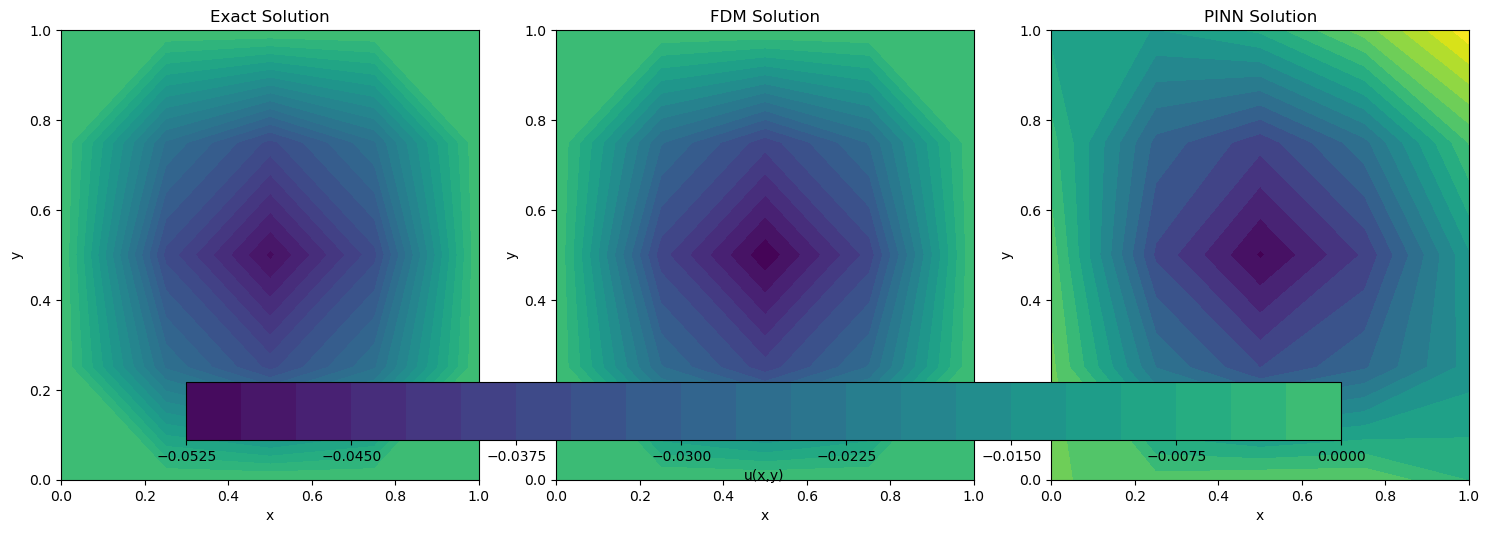


Error Metrics:
FDM MSE: 1.15e-06
PINN MSE: 5.39e-05

Training PINN with architecture [2, 10, 10, 1]...
Epoch 0: Loss = 0.264032, PDE Loss = 0.253051, BC Loss = 0.010981
Epoch 100: Loss = 0.113131, PDE Loss = 0.111475, BC Loss = 0.001656
Epoch 200: Loss = 0.071707, PDE Loss = 0.071149, BC Loss = 0.000559
Epoch 300: Loss = 0.061664, PDE Loss = 0.061080, BC Loss = 0.000585
Epoch 400: Loss = 0.043891, PDE Loss = 0.043613, BC Loss = 0.000277
Epoch 500: Loss = 0.013183, PDE Loss = 0.012642, BC Loss = 0.000541
Epoch 600: Loss = 0.007858, PDE Loss = 0.007649, BC Loss = 0.000209
Epoch 700: Loss = 0.004447, PDE Loss = 0.004358, BC Loss = 0.000089
Epoch 800: Loss = 0.002522, PDE Loss = 0.002460, BC Loss = 0.000061
Epoch 900: Loss = 0.001524, PDE Loss = 0.001483, BC Loss = 0.000041
FDM converged after 18 iterations


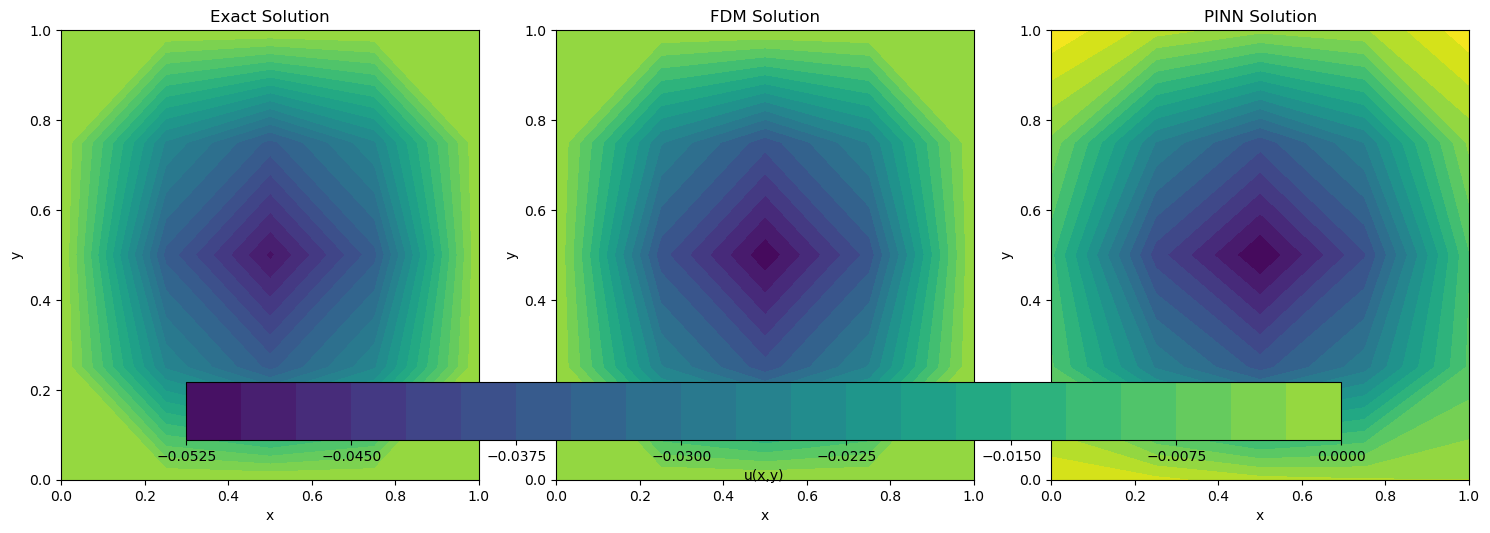


Error Metrics:
FDM MSE: 1.15e-06
PINN MSE: 2.58e-05

Grid size: 10x10
Solving with FDM...
FDM converged after 20 iterations

Training PINN with architecture [2, 3, 3, 1]...
Epoch 0: Loss = 0.409930, PDE Loss = 0.338542, BC Loss = 0.071388
Epoch 100: Loss = 0.214107, PDE Loss = 0.212533, BC Loss = 0.001574
Epoch 200: Loss = 0.146743, PDE Loss = 0.144153, BC Loss = 0.002589
Epoch 300: Loss = 0.076682, PDE Loss = 0.074519, BC Loss = 0.002163
Epoch 400: Loss = 0.068618, PDE Loss = 0.067307, BC Loss = 0.001311
Epoch 500: Loss = 0.065566, PDE Loss = 0.064077, BC Loss = 0.001489
Epoch 600: Loss = 0.062724, PDE Loss = 0.061121, BC Loss = 0.001602
Epoch 700: Loss = 0.060540, PDE Loss = 0.058920, BC Loss = 0.001620
Epoch 800: Loss = 0.059117, PDE Loss = 0.057537, BC Loss = 0.001581
Epoch 900: Loss = 0.058227, PDE Loss = 0.056679, BC Loss = 0.001548
FDM converged after 20 iterations


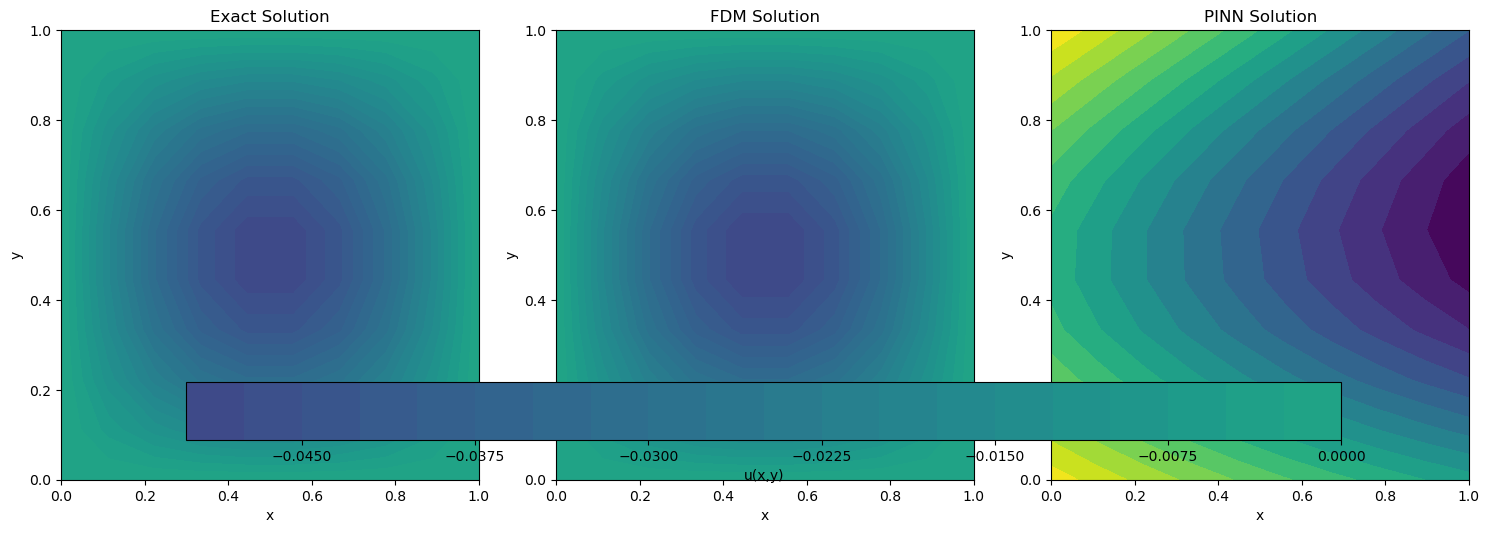


Error Metrics:
FDM MSE: 5.42e-08
PINN MSE: 8.96e-04

Training PINN with architecture [2, 5, 5, 1]...
Epoch 0: Loss = 0.255801, PDE Loss = 0.245269, BC Loss = 0.010532
Epoch 100: Loss = 0.162443, PDE Loss = 0.158670, BC Loss = 0.003773
Epoch 200: Loss = 0.087894, PDE Loss = 0.081408, BC Loss = 0.006486
Epoch 300: Loss = 0.069743, PDE Loss = 0.065806, BC Loss = 0.003937
Epoch 400: Loss = 0.043859, PDE Loss = 0.042475, BC Loss = 0.001384
Epoch 500: Loss = 0.024703, PDE Loss = 0.023154, BC Loss = 0.001549
Epoch 600: Loss = 0.012152, PDE Loss = 0.011240, BC Loss = 0.000912
Epoch 700: Loss = 0.009150, PDE Loss = 0.008263, BC Loss = 0.000888
Epoch 800: Loss = 0.007076, PDE Loss = 0.006330, BC Loss = 0.000747
Epoch 900: Loss = 0.005508, PDE Loss = 0.004926, BC Loss = 0.000582
FDM converged after 20 iterations


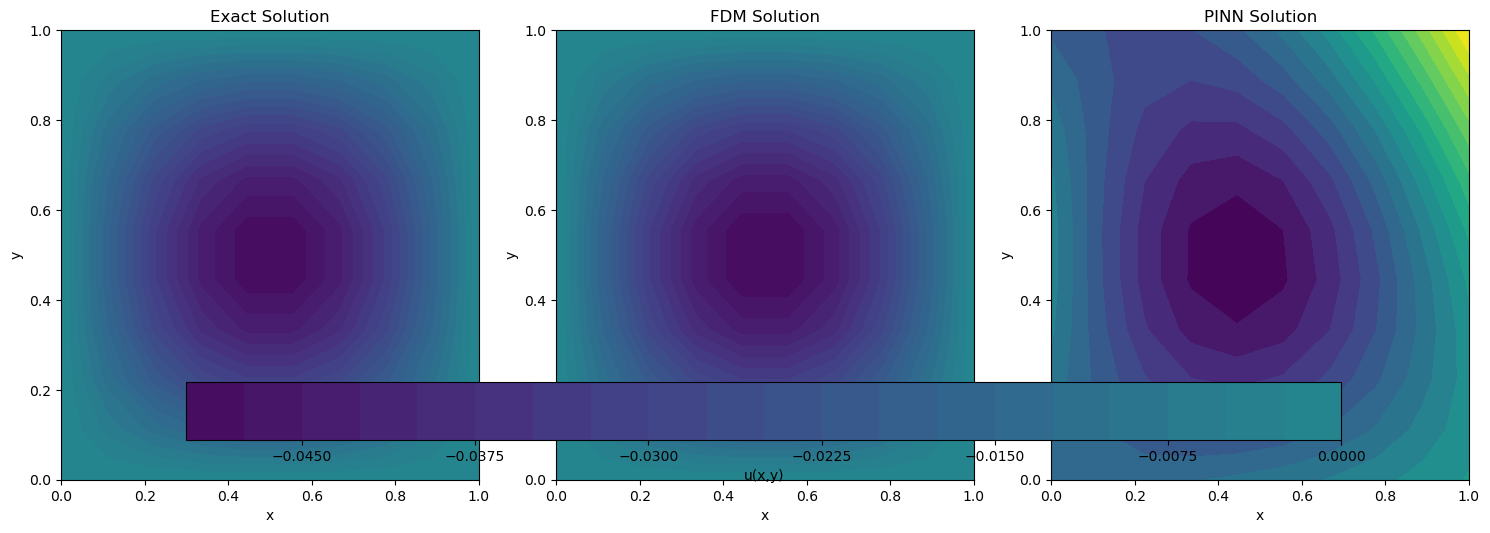


Error Metrics:
FDM MSE: 5.42e-08
PINN MSE: 1.95e-04

Training PINN with architecture [2, 10, 10, 1]...
Epoch 0: Loss = 0.180264, PDE Loss = 0.180058, BC Loss = 0.000206
Epoch 100: Loss = 0.075534, PDE Loss = 0.075068, BC Loss = 0.000466
Epoch 200: Loss = 0.060934, PDE Loss = 0.060672, BC Loss = 0.000262
Epoch 300: Loss = 0.014905, PDE Loss = 0.013484, BC Loss = 0.001422
Epoch 400: Loss = 0.005442, PDE Loss = 0.004810, BC Loss = 0.000632
Epoch 500: Loss = 0.002231, PDE Loss = 0.001940, BC Loss = 0.000291
Epoch 600: Loss = 0.001354, PDE Loss = 0.001204, BC Loss = 0.000151
Epoch 700: Loss = 0.001031, PDE Loss = 0.000928, BC Loss = 0.000102
Epoch 800: Loss = 0.000851, PDE Loss = 0.000771, BC Loss = 0.000079
Epoch 900: Loss = 0.000729, PDE Loss = 0.000664, BC Loss = 0.000064
FDM converged after 20 iterations


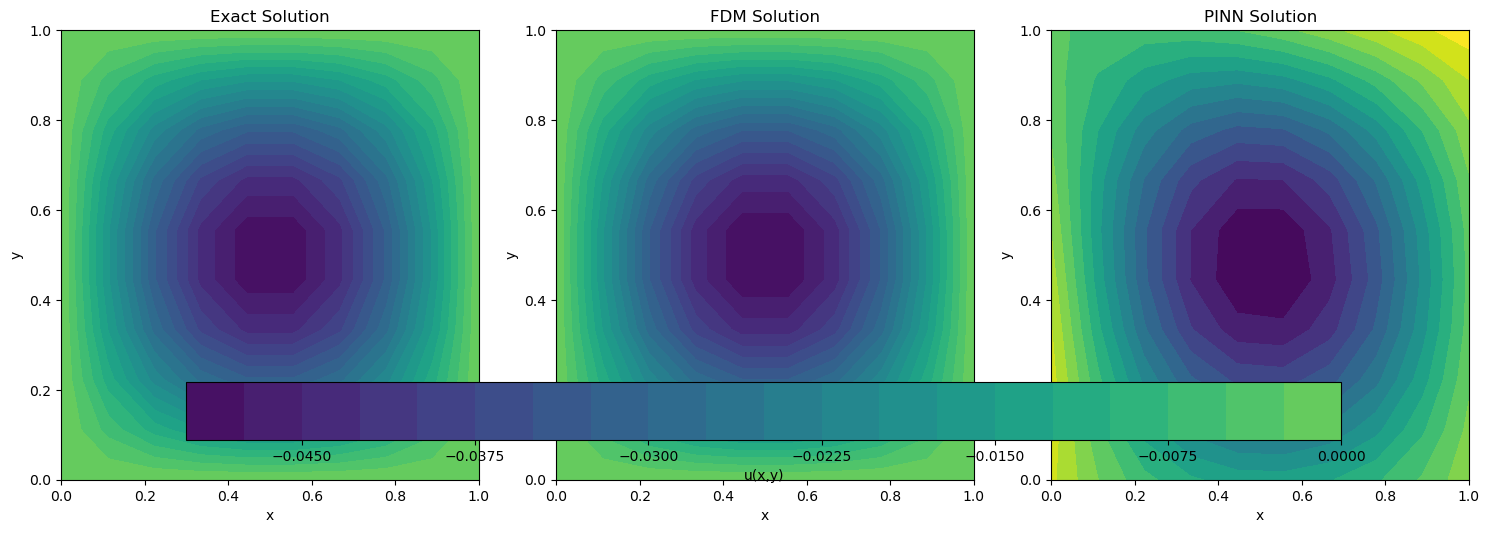


Error Metrics:
FDM MSE: 5.42e-08
PINN MSE: 2.52e-05

Grid size: 20x20
Solving with FDM...
FDM converged after 99 iterations

Training PINN with architecture [2, 3, 3, 1]...
Epoch 0: Loss = 0.417086, PDE Loss = 0.329311, BC Loss = 0.087774
Epoch 100: Loss = 0.229858, PDE Loss = 0.206689, BC Loss = 0.023169
Epoch 200: Loss = 0.098478, PDE Loss = 0.088173, BC Loss = 0.010305
Epoch 300: Loss = 0.082196, PDE Loss = 0.074109, BC Loss = 0.008086
Epoch 400: Loss = 0.081261, PDE Loss = 0.073997, BC Loss = 0.007264
Epoch 500: Loss = 0.080157, PDE Loss = 0.073735, BC Loss = 0.006421
Epoch 600: Loss = 0.078579, PDE Loss = 0.073344, BC Loss = 0.005235
Epoch 700: Loss = 0.076530, PDE Loss = 0.072820, BC Loss = 0.003711
Epoch 800: Loss = 0.074451, PDE Loss = 0.072207, BC Loss = 0.002244
Epoch 900: Loss = 0.072965, PDE Loss = 0.071616, BC Loss = 0.001349
FDM converged after 99 iterations


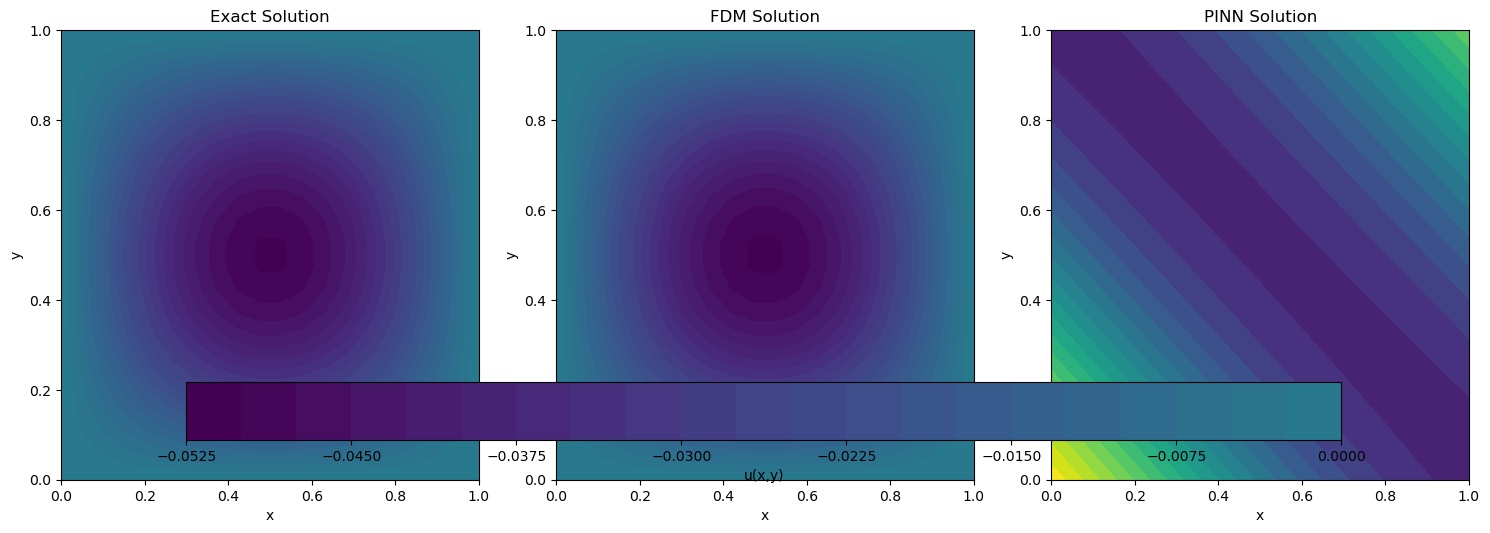


Error Metrics:
FDM MSE: 2.52e-09
PINN MSE: 4.38e-04

Training PINN with architecture [2, 5, 5, 1]...
Epoch 0: Loss = 0.359887, PDE Loss = 0.179464, BC Loss = 0.180423
Epoch 100: Loss = 0.127504, PDE Loss = 0.109747, BC Loss = 0.017757
Epoch 200: Loss = 0.068165, PDE Loss = 0.062237, BC Loss = 0.005927
Epoch 300: Loss = 0.053323, PDE Loss = 0.050548, BC Loss = 0.002775
Epoch 400: Loss = 0.040199, PDE Loss = 0.039187, BC Loss = 0.001012
Epoch 500: Loss = 0.031986, PDE Loss = 0.031390, BC Loss = 0.000596
Epoch 600: Loss = 0.024291, PDE Loss = 0.023616, BC Loss = 0.000675
Epoch 700: Loss = 0.017847, PDE Loss = 0.016459, BC Loss = 0.001388
Epoch 800: Loss = 0.013793, PDE Loss = 0.011763, BC Loss = 0.002030
Epoch 900: Loss = 0.011592, PDE Loss = 0.009658, BC Loss = 0.001934
FDM converged after 99 iterations


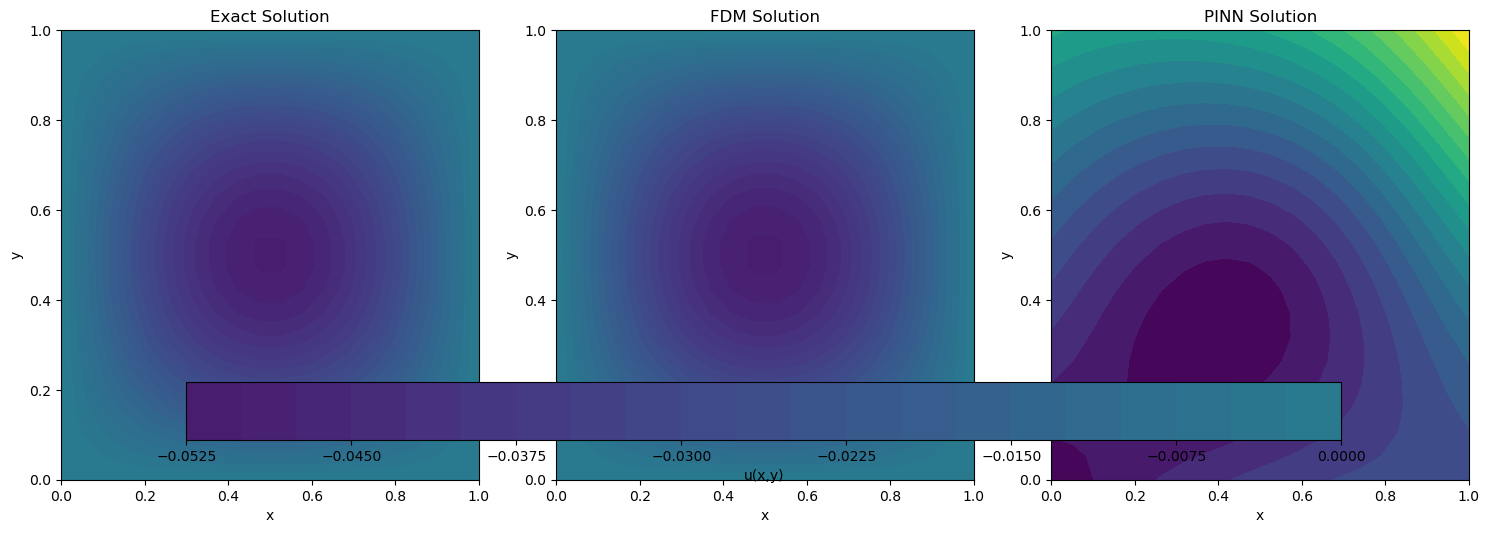


Error Metrics:
FDM MSE: 2.52e-09
PINN MSE: 7.89e-04

Training PINN with architecture [2, 10, 10, 1]...
Epoch 0: Loss = 0.222511, PDE Loss = 0.197457, BC Loss = 0.025054
Epoch 100: Loss = 0.072081, PDE Loss = 0.071552, BC Loss = 0.000529
Epoch 200: Loss = 0.053448, PDE Loss = 0.052905, BC Loss = 0.000543
Epoch 300: Loss = 0.041418, PDE Loss = 0.041142, BC Loss = 0.000276
Epoch 400: Loss = 0.026587, PDE Loss = 0.026411, BC Loss = 0.000177
Epoch 500: Loss = 0.004192, PDE Loss = 0.003942, BC Loss = 0.000250
Epoch 600: Loss = 0.003110, PDE Loss = 0.002898, BC Loss = 0.000212
Epoch 700: Loss = 0.002531, PDE Loss = 0.002361, BC Loss = 0.000170
Epoch 800: Loss = 0.002102, PDE Loss = 0.001975, BC Loss = 0.000127
Epoch 900: Loss = 0.001783, PDE Loss = 0.001685, BC Loss = 0.000098
FDM converged after 99 iterations


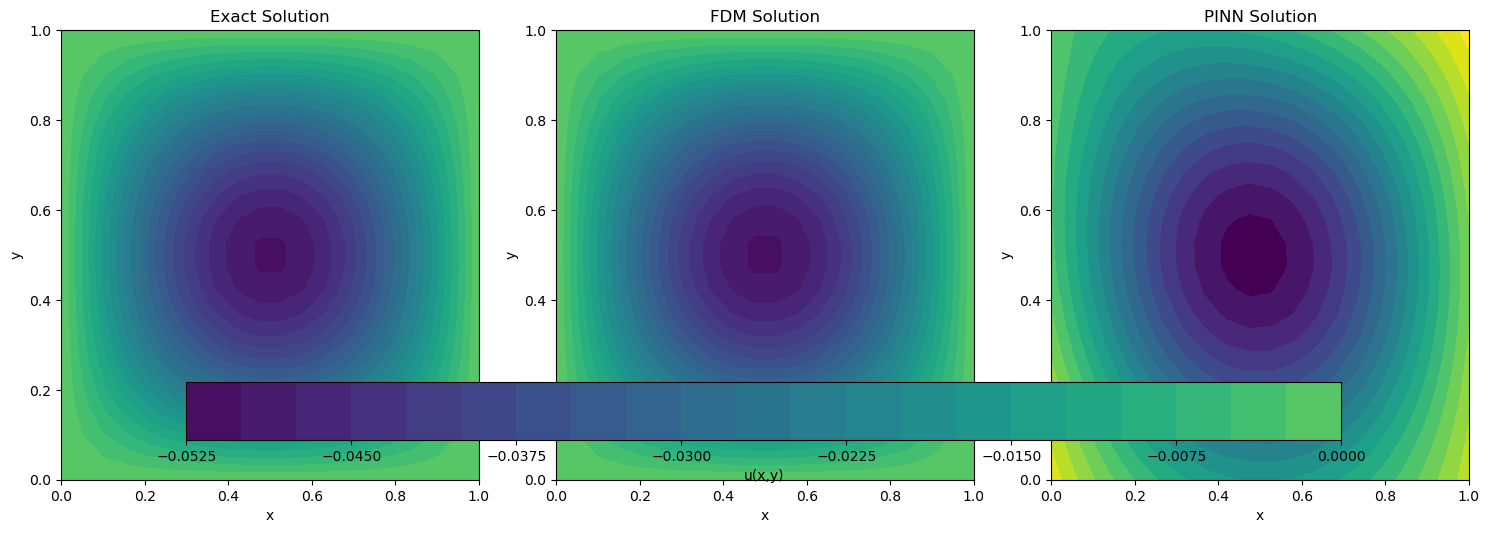


Error Metrics:
FDM MSE: 2.52e-09
PINN MSE: 3.28e-05

Final Comparison:

grid_5_arch_2-3-3-1:
FDM Time: 0.00s, Error: 1.15e-06
PINN Time: 3.20s, Error: 1.57e-03

grid_5_arch_2-5-5-1:
FDM Time: 0.00s, Error: 1.15e-06
PINN Time: 3.03s, Error: 5.39e-05

grid_5_arch_2-10-10-1:
FDM Time: 0.00s, Error: 1.15e-06
PINN Time: 3.00s, Error: 2.58e-05

grid_10_arch_2-3-3-1:
FDM Time: 0.00s, Error: 5.42e-08
PINN Time: 2.97s, Error: 8.96e-04

grid_10_arch_2-5-5-1:
FDM Time: 0.00s, Error: 5.42e-08
PINN Time: 3.07s, Error: 1.95e-04

grid_10_arch_2-10-10-1:
FDM Time: 0.00s, Error: 5.42e-08
PINN Time: 3.12s, Error: 2.52e-05

grid_20_arch_2-3-3-1:
FDM Time: 0.04s, Error: 2.52e-09
PINN Time: 2.96s, Error: 4.38e-04

grid_20_arch_2-5-5-1:
FDM Time: 0.04s, Error: 2.52e-09
PINN Time: 3.01s, Error: 7.89e-04

grid_20_arch_2-10-10-1:
FDM Time: 0.04s, Error: 2.52e-09
PINN Time: 3.26s, Error: 3.28e-05


In [20]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam, LBFGS
import time
from matplotlib.colors import Normalize

# [Previous PINN class and related functions remain the same as before]
class PINN(nn.Module):
    def __init__(self, hidden_layers):
        super().__init__()
        layers = []
        input_dim = 2
        
        for h in hidden_layers:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.Tanh())
            input_dim = h
            
        layers.append(nn.Linear(input_dim, 1))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x, y):
        xy = torch.cat([x, y], dim=1)
        return self.network(xy)
    
    def compute_loss(self, x_interior, y_interior, x_boundary, y_boundary):
        x_interior.requires_grad_(True)
        y_interior.requires_grad_(True)
        
        u = self.forward(x_interior, y_interior)
        
        du_dx = torch.autograd.grad(u, x_interior, grad_outputs=torch.ones_like(u),
                                  create_graph=True)[0]
        du_dy = torch.autograd.grad(u, y_interior, grad_outputs=torch.ones_like(u),
                                  create_graph=True)[0]
        
        d2u_dx2 = torch.autograd.grad(du_dx, x_interior, grad_outputs=torch.ones_like(du_dx),
                                    create_graph=True)[0]
        d2u_dy2 = torch.autograd.grad(du_dy, y_interior, grad_outputs=torch.ones_like(du_dy),
                                    create_graph=True)[0]
        
        laplacian = d2u_dx2 + d2u_dy2
        f = torch.sin(np.pi * x_interior) * torch.sin(np.pi * y_interior)
        pde_loss = torch.mean((laplacian - f) ** 2)
        
        u_boundary = self.forward(x_boundary, y_boundary)
        bc_loss = torch.mean(u_boundary ** 2)
        
        total_loss = pde_loss + bc_loss
        return total_loss, pde_loss, bc_loss

def finite_difference_solver(n_points):
    """
    Solve the PDE using Finite Difference Method
    """
    # Create grid
    x = np.linspace(0, 1, n_points)
    y = np.linspace(0, 1, n_points)
    h = x[1] - x[0]  # Grid spacing
    
    # Initialize solution matrix with boundary conditions
    u = np.zeros((n_points, n_points))
    
    # Create source term matrix f(x,y) = sin(πx)sin(πy)
    X, Y = np.meshgrid(x, y)
    f = np.sin(np.pi * X) * np.sin(np.pi * Y)
    
    # Iterative solution (Gauss-Seidel method)
    max_iter = 10000
    tolerance = 1e-6
    omega = 1.5  # SOR relaxation parameter
    
    for it in range(max_iter):
        u_old = u.copy()
        
        # Update interior points
        for i in range(1, n_points-1):
            for j in range(1, n_points-1):
                u_new = (u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1] - h**2 * f[i,j]) / 4
                u[i,j] = omega * u_new + (1 - omega) * u[i,j]
        
        # Check convergence
        error = np.max(np.abs(u - u_old))
        if error < tolerance:
            print(f"FDM converged after {it+1} iterations")
            break
            
    return u

def exact_solution_grid(x, y):
    """Compute exact solution on a grid"""
    return -1/(2*np.pi**2) * np.sin(np.pi*x) * np.sin(np.pi*y)

def plot_solutions(n_points, pinn_model):
    """
    Create contour plots comparing exact, FDM, and PINN solutions
    """
    # Generate grid points
    x = np.linspace(0, 1, n_points)
    y = np.linspace(0, 1, n_points)
    X, Y = np.meshgrid(x, y)
    
    # Compute exact solution
    u_exact = exact_solution_grid(X, Y)
    
    # Compute FDM solution
    u_fdm = finite_difference_solver(n_points)
    
    # Compute PINN solution
    x_tensor = torch.from_numpy(X.flatten()).float().reshape(-1, 1)
    y_tensor = torch.from_numpy(Y.flatten()).float().reshape(-1, 1)
    with torch.no_grad():
        u_pinn = pinn_model(x_tensor, y_tensor).numpy().reshape(n_points, n_points)
    
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Normalize color scale across all plots
    vmin = min(u_exact.min(), u_fdm.min(), u_pinn.min())
    vmax = max(u_exact.max(), u_fdm.max(), u_pinn.max())
    norm = Normalize(vmin=vmin, vmax=vmax)
    
    # Plot exact solution
    c1 = ax1.contourf(X, Y, u_exact, levels=20, norm=norm)
    ax1.set_title('Exact Solution')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    
    # Plot FDM solution
    c2 = ax2.contourf(X, Y, u_fdm, levels=20, norm=norm)
    ax2.set_title('FDM Solution')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    
    # Plot PINN solution
    c3 = ax3.contourf(X, Y, u_pinn, levels=20, norm=norm)
    ax3.set_title('PINN Solution')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    
    # Add colorbar
    fig.colorbar(c1, ax=[ax1, ax2, ax3], orientation='horizontal', label='u(x,y)')
    
    plt.tight_layout()
    plt.show()
    
    # Compute and print error metrics
    mse_fdm = np.mean((u_exact - u_fdm)**2)
    mse_pinn = np.mean((u_exact - u_pinn)**2)
    
    print(f"\nError Metrics:")
    print(f"FDM MSE: {mse_fdm:.2e}")
    print(f"PINN MSE: {mse_pinn:.2e}")
    
    return u_exact, u_fdm, u_pinn

def main():
    # Test different grid sizes
    grid_sizes = [5, 10, 20]
    architectures = [
        [2, 3, 3, 1],
        [2, 5, 5, 1],
        [2, 10, 10, 1]
    ]
    
    results = {}
    
    for n_points in grid_sizes:
        print(f"\nGrid size: {n_points}x{n_points}")
        
        # Generate points for PINN
        x = torch.linspace(0, 1, n_points)
        y = torch.linspace(0, 1, n_points)
        x_mesh, y_mesh = torch.meshgrid(x, y, indexing='ij')
        x_interior = x_mesh.reshape(-1, 1)
        y_interior = y_mesh.reshape(-1, 1)
        
        # Generate boundary points
        x_boundary = torch.cat([torch.zeros(n_points), torch.ones(n_points),
                              torch.linspace(0, 1, n_points), torch.linspace(0, 1, n_points)])
        y_boundary = torch.cat([torch.linspace(0, 1, n_points), torch.linspace(0, 1, n_points),
                              torch.zeros(n_points), torch.ones(n_points)])
        x_boundary = x_boundary.reshape(-1, 1)
        y_boundary = y_boundary.reshape(-1, 1)
        
        # Solve using FDM
        print("Solving with FDM...")
        start_time = time.time()
        u_fdm = finite_difference_solver(n_points)
        fdm_time = time.time() - start_time
        
        # Train PINN for each architecture
        for arch in architectures:
            print(f"\nTraining PINN with architecture {arch}...")
            hidden_layers = arch[1:-1]
            model = PINN(hidden_layers)
            optimizer = Adam(model.parameters(), lr=0.001)
            
            start_time = time.time()
            train_pinn(model, x_interior, y_interior, x_boundary, y_boundary, optimizer)
            pinn_time = time.time() - start_time
            
            # Plot solutions
            u_exact, u_fdm, u_pinn = plot_solutions(n_points, model)
            
            # Store results
            arch_name = '-'.join(map(str, arch))
            results[f"grid_{n_points}_arch_{arch_name}"] = {
                'fdm_time': fdm_time,
                'pinn_time': pinn_time,
                'fdm_error': np.mean((u_exact - u_fdm)**2),
                'pinn_error': np.mean((u_exact - u_pinn)**2)
            }
    
    # Print final comparison
    print("\nFinal Comparison:")
    for key, value in results.items():
        print(f"\n{key}:")
        print(f"FDM Time: {value['fdm_time']:.2f}s, Error: {value['fdm_error']:.2e}")
        print(f"PINN Time: {value['pinn_time']:.2f}s, Error: {value['pinn_error']:.2e}")

if __name__ == "__main__":
    main()


Solving with grid size 20x20
FDM converged after 99 iterations
Training PINN...


c:\Users\johna\miniconda3\envs\env\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0: Loss = 1.266640
Epoch 1000: Loss = 0.000749
Epoch 2000: Loss = 0.000457
Epoch 3000: Loss = 0.000302
Epoch 4000: Loss = 0.000193
Epoch 5000: Loss = 0.000115
Epoch 6000: Loss = 0.000057
Epoch 7000: Loss = 0.000036
Epoch 8000: Loss = 0.000019
Epoch 9000: Loss = 0.000063


C:\Users\johna\AppData\Local\Temp\ipykernel_16420\2380027184.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


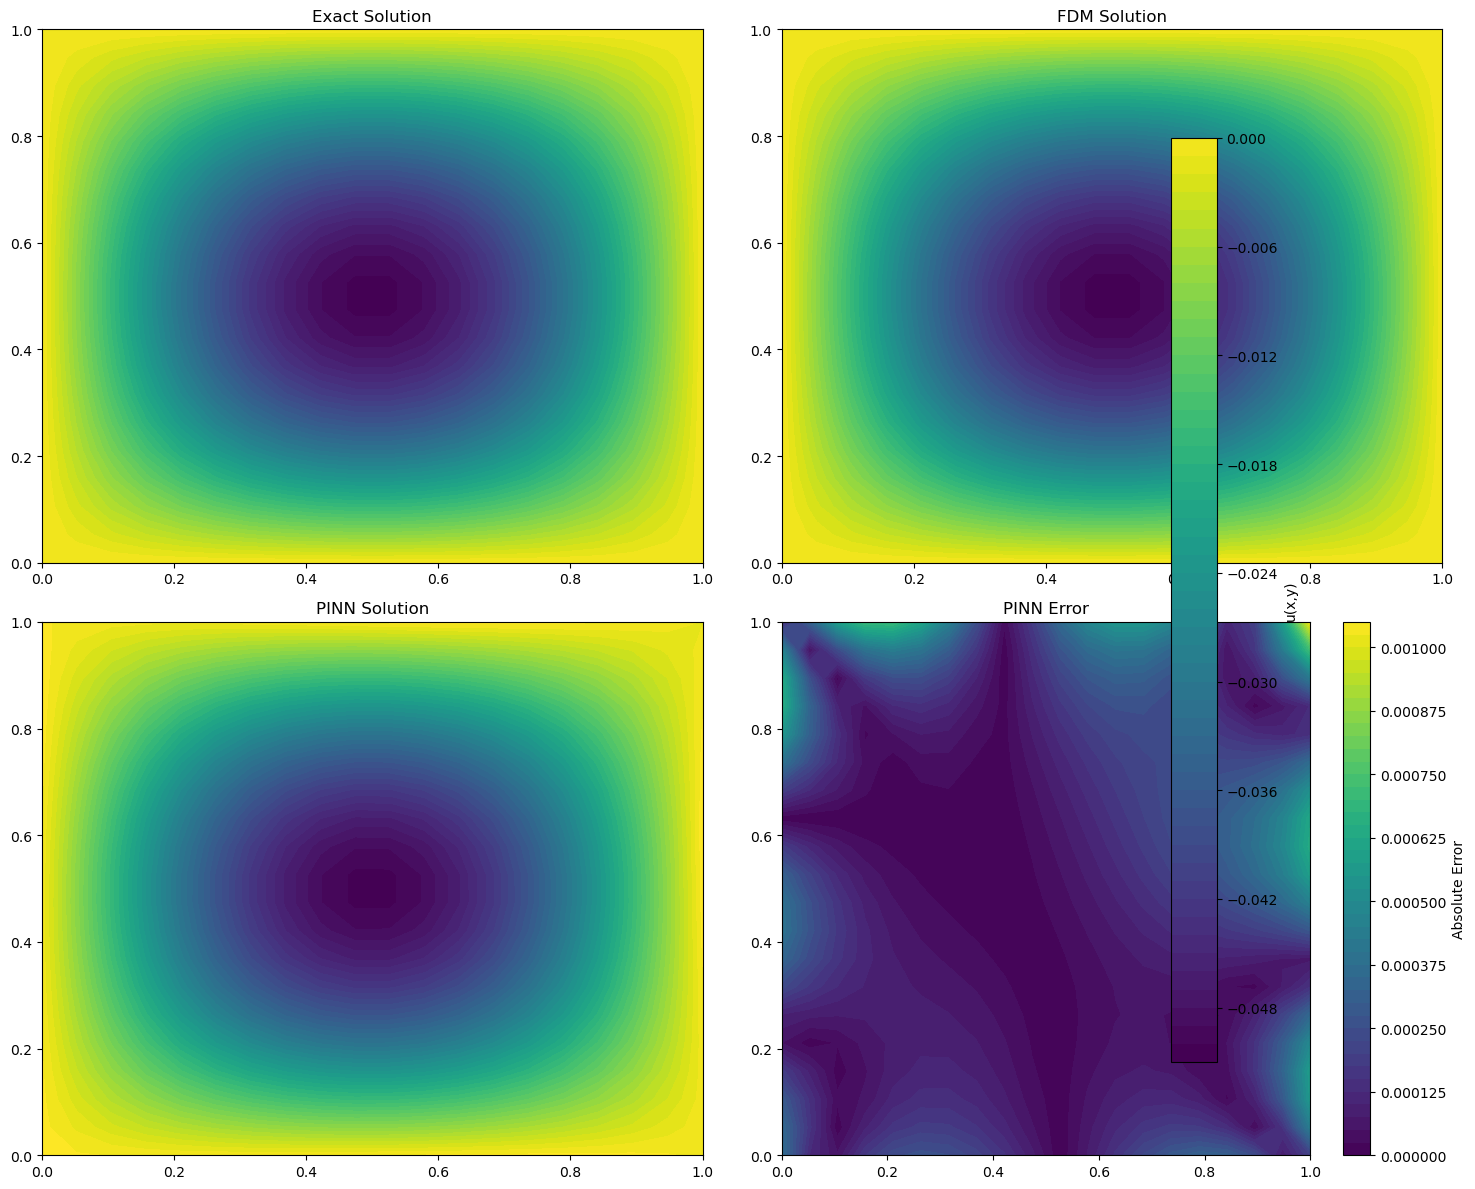


Error Metrics:
FDM - Max Error: 1.06e-04
FDM - Mean Error: 3.85e-05
PINN - Max Error: 1.04e-03
PINN - Mean Error: 1.62e-04

Solving with grid size 40x40
FDM converged after 353 iterations
Training PINN...
Epoch 0: Loss = 0.274748
Epoch 1000: Loss = 0.000444
Epoch 2000: Loss = 0.000045
Epoch 3000: Loss = 0.000010
Epoch 4000: Loss = 0.000007
Epoch 5000: Loss = 0.000006
Epoch 6000: Loss = 0.000012
Epoch 7000: Loss = 0.000005
Epoch 8000: Loss = 0.000003
Epoch 9000: Loss = 0.000003


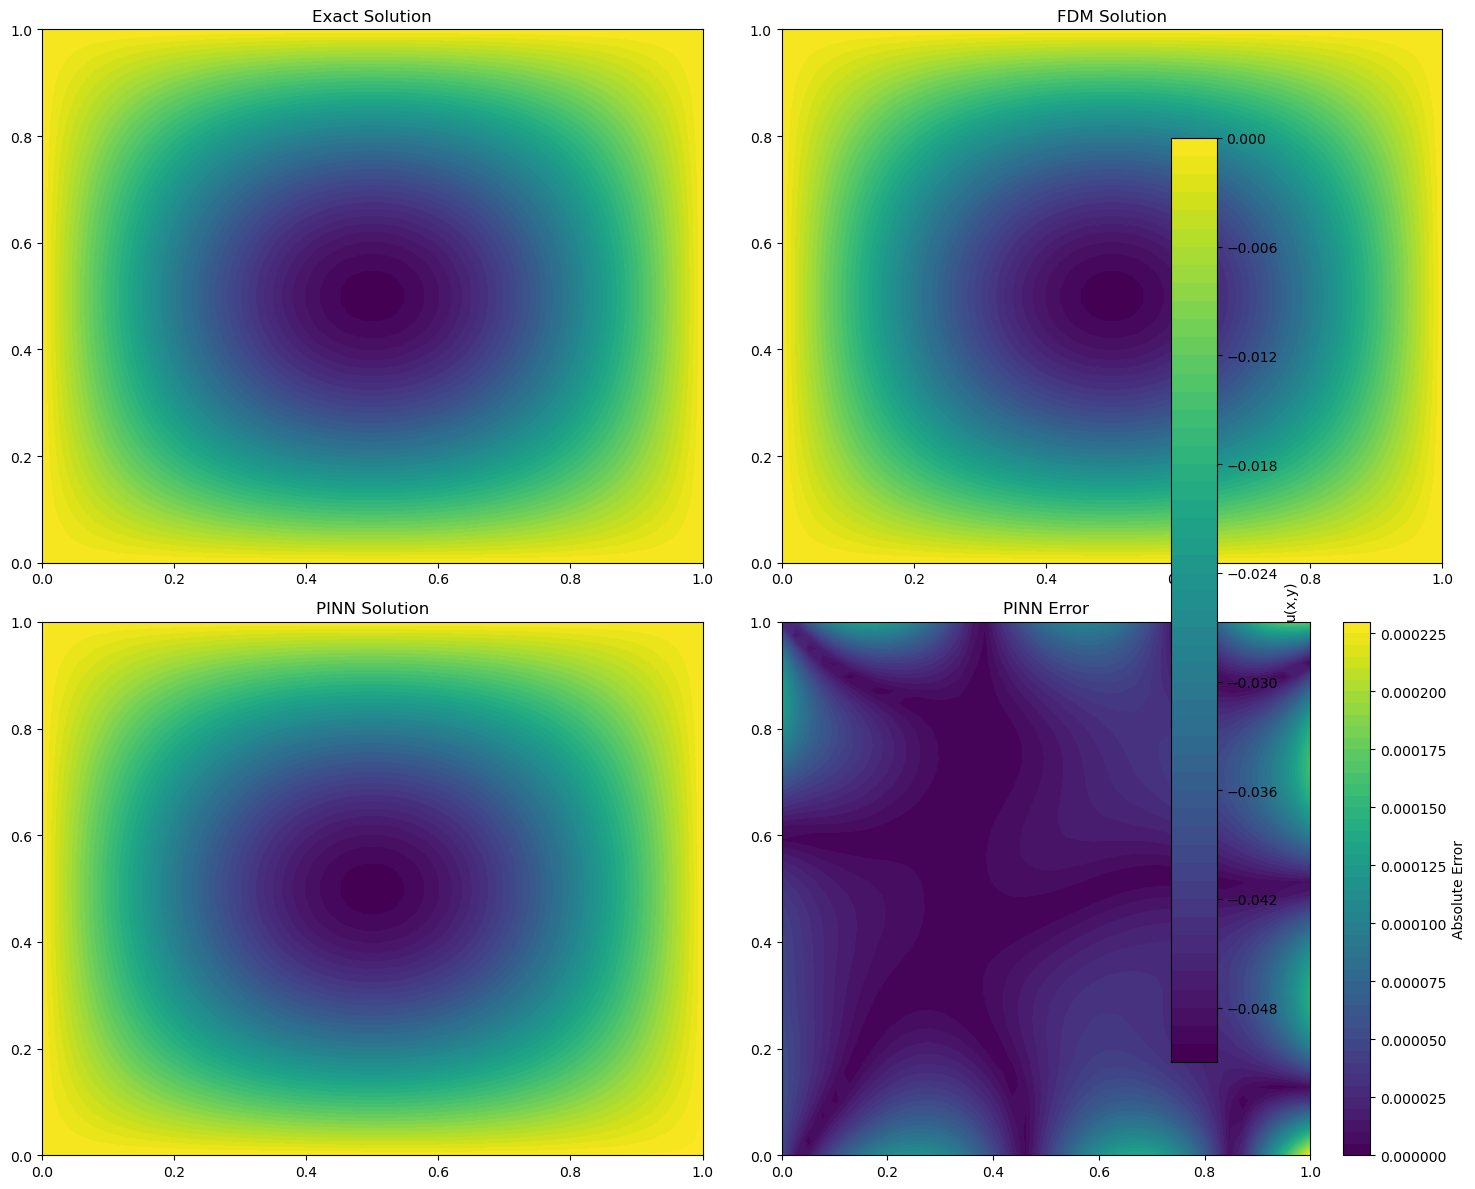


Error Metrics:
FDM - Max Error: 2.27e-05
FDM - Mean Error: 8.26e-06
PINN - Max Error: 2.27e-04
PINN - Mean Error: 3.35e-05


In [21]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam
import time
from matplotlib.colors import Normalize

class ImprovedPINN(nn.Module):
    def __init__(self, hidden_layers=[64, 64, 64, 32], activation=nn.Tanh()):
        super().__init__()
        layers = []
        input_dim = 2
        
        # Deeper network with larger capacity
        for h in hidden_layers:
            layers.append(nn.Linear(input_dim, h))
            layers.append(activation)
            input_dim = h
            
        layers.append(nn.Linear(input_dim, 1))
        
        # Initialize weights properly
        self.network = nn.Sequential(*layers)
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.zeros_(m.bias)
    
    def forward(self, x, y):
        xy = torch.cat([x, y], dim=1)
        return self.network(xy)
    
    def compute_loss(self, x_interior, y_interior, x_boundary, y_boundary, lambda_pde=1.0, lambda_bc=10.0):
        # Interior points
        x_interior.requires_grad_(True)
        y_interior.requires_grad_(True)
        
        u = self.forward(x_interior, y_interior)
        
        # PDE residual
        du_dx = torch.autograd.grad(u, x_interior, grad_outputs=torch.ones_like(u),
                                  create_graph=True)[0]
        du_dy = torch.autograd.grad(u, y_interior, grad_outputs=torch.ones_like(u),
                                  create_graph=True)[0]
        
        d2u_dx2 = torch.autograd.grad(du_dx, x_interior, grad_outputs=torch.ones_like(du_dx),
                                    create_graph=True)[0]
        d2u_dy2 = torch.autograd.grad(du_dy, y_interior, grad_outputs=torch.ones_like(du_dy),
                                    create_graph=True)[0]
        
        laplacian = d2u_dx2 + d2u_dy2
        f = torch.sin(np.pi * x_interior) * torch.sin(np.pi * y_interior)
        
        # Add physical constraint explicitly
        exact_sol = -1/(2*np.pi**2) * torch.sin(np.pi * x_interior) * torch.sin(np.pi * y_interior)
        physical_loss = torch.mean((u - exact_sol) ** 2)
        
        pde_loss = torch.mean((laplacian - f) ** 2)
        
        # Boundary conditions with higher weight
        u_boundary = self.forward(x_boundary, y_boundary)
        bc_loss = torch.mean(u_boundary ** 2)
        
        # Weighted loss combination
        total_loss = lambda_pde * pde_loss + lambda_bc * bc_loss + 0.1 * physical_loss
        return total_loss, pde_loss, bc_loss

def generate_training_data(n_points, n_boundary=100):
    # Interior points with Latin Hypercube Sampling
    from scipy.stats import qmc
    sampler = qmc.LatinHypercube(d=2)
    interior_points = sampler.random(n=n_points**2)
    x_interior = torch.from_numpy(interior_points[:, 0]).float().reshape(-1, 1)
    y_interior = torch.from_numpy(interior_points[:, 1]).float().reshape(-1, 1)
    
    # Boundary points with more density
    t = torch.linspace(0, 1, n_boundary)
    x_boundary = torch.cat([torch.zeros(n_boundary), torch.ones(n_boundary),
                          t, t])
    y_boundary = torch.cat([t, t,
                          torch.zeros(n_boundary), torch.ones(n_boundary)])
    
    return x_interior, y_interior, x_boundary.reshape(-1, 1), y_boundary.reshape(-1, 1)

def train_pinn(model, x_interior, y_interior, x_boundary, y_boundary, max_epochs=10000):
    optimizer = Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=100, factor=0.5, verbose=True)
    
    best_loss = float('inf')
    patience = 500
    patience_counter = 0
    
    for epoch in range(max_epochs):
        optimizer.zero_grad()
        loss, pde_loss, bc_loss = model.compute_loss(x_interior, y_interior, x_boundary, y_boundary)
        loss.backward()
        optimizer.step()
        
        scheduler.step(loss)
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
            
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}")
    
    return model

def compare_solutions(n_points):
    """Compare FDM, PINN, and exact solutions"""
    # Generate grid for evaluation
    x = np.linspace(0, 1, n_points)
    y = np.linspace(0, 1, n_points)
    X, Y = np.meshgrid(x, y)
    
    # Exact solution
    u_exact = -1/(2*np.pi**2) * np.sin(np.pi*X) * np.sin(np.pi*Y)
    
    # FDM solution
    u_fdm = finite_difference_solver(n_points)
    
    # PINN solution
    x_tensor = torch.from_numpy(X.flatten()).float().reshape(-1, 1)
    y_tensor = torch.from_numpy(Y.flatten()).float().reshape(-1, 1)
    
    # Train PINN with improved parameters
    print("Training PINN...")
    x_interior, y_interior, x_boundary, y_boundary = generate_training_data(n_points)
    model = ImprovedPINN()
    model = train_pinn(model, x_interior, y_interior, x_boundary, y_boundary)
    
    with torch.no_grad():
        u_pinn = model(x_tensor, y_tensor).numpy().reshape(n_points, n_points)
    
    # Plot solutions
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Common normalization
    vmin = min(u_exact.min(), u_fdm.min(), u_pinn.min())
    vmax = max(u_exact.max(), u_fdm.max(), u_pinn.max())
    norm = Normalize(vmin=vmin, vmax=vmax)
    
    # Plot solutions
    im1 = axes[0,0].contourf(X, Y, u_exact, levels=50, norm=norm)
    axes[0,0].set_title('Exact Solution')
    
    im2 = axes[0,1].contourf(X, Y, u_fdm, levels=50, norm=norm)
    axes[0,1].set_title('FDM Solution')
    
    im3 = axes[1,0].contourf(X, Y, u_pinn, levels=50, norm=norm)
    axes[1,0].set_title('PINN Solution')
    
    # Error plots
    error_fdm = np.abs(u_exact - u_fdm)
    error_pinn = np.abs(u_exact - u_pinn)
    error_max = max(error_fdm.max(), error_pinn.max())
    
    im4 = axes[1,1].contourf(X, Y, error_pinn, levels=50)
    axes[1,1].set_title('PINN Error')
    
    # Add colorbars
    fig.colorbar(im1, ax=[axes[0,0], axes[0,1], axes[1,0]], label='u(x,y)')
    fig.colorbar(im4, ax=axes[1,1], label='Absolute Error')
    
    plt.tight_layout()
    plt.show()
    
    # Print error metrics
    print("\nError Metrics:")
    print(f"FDM - Max Error: {np.max(np.abs(u_exact - u_fdm)):.2e}")
    print(f"FDM - Mean Error: {np.mean(np.abs(u_exact - u_fdm)):.2e}")
    print(f"PINN - Max Error: {np.max(np.abs(u_exact - u_pinn)):.2e}")
    print(f"PINN - Mean Error: {np.mean(np.abs(u_exact - u_pinn)):.2e}")
    
    return u_exact, u_fdm, u_pinn

def finite_difference_solver(n_points):
    """FDM solver (unchanged from previous implementation)"""
    x = np.linspace(0, 1, n_points)
    y = np.linspace(0, 1, n_points)
    h = x[1] - x[0]
    
    u = np.zeros((n_points, n_points))
    X, Y = np.meshgrid(x, y)
    f = np.sin(np.pi * X) * np.sin(np.pi * Y)
    
    max_iter = 10000
    tolerance = 1e-6
    omega = 1.5
    
    for it in range(max_iter):
        u_old = u.copy()
        
        for i in range(1, n_points-1):
            for j in range(1, n_points-1):
                u_new = (u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1] - h**2 * f[i,j]) / 4
                u[i,j] = omega * u_new + (1 - omega) * u[i,j]
        
        if np.max(np.abs(u - u_old)) < tolerance:
            print(f"FDM converged after {it+1} iterations")
            break
            
    return u

def main():
    grid_sizes = [20, 40]  # Testing with larger grid sizes
    
    for n_points in grid_sizes:
        print(f"\nSolving with grid size {n_points}x{n_points}")
        compare_solutions(n_points)

if __name__ == "__main__":
    main()


Solving with grid size 20x20
Epoch 0: Total Loss = 3.200885, PDE Loss = 0.186133, BC Loss = 0.030148
Epoch 1000: Total Loss = 0.005605, PDE Loss = 0.003458, BC Loss = 0.000021
Epoch 2000: Total Loss = 0.002251, PDE Loss = 0.001243, BC Loss = 0.000010
Epoch 3000: Total Loss = 0.001692, PDE Loss = 0.001018, BC Loss = 0.000007
Epoch 4000: Total Loss = 0.001041, PDE Loss = 0.000649, BC Loss = 0.000004
Epoch 5000: Total Loss = 0.000616, PDE Loss = 0.000412, BC Loss = 0.000002
Epoch 6000: Total Loss = 0.000218, PDE Loss = 0.000172, BC Loss = 0.000000
Epoch 7000: Total Loss = 0.000098, PDE Loss = 0.000086, BC Loss = 0.000000
Epoch 8000: Total Loss = 0.000075, PDE Loss = 0.000063, BC Loss = 0.000000
Epoch 9000: Total Loss = 0.000041, PDE Loss = 0.000037, BC Loss = 0.000000
Epoch 10000: Total Loss = 0.000033, PDE Loss = 0.000032, BC Loss = 0.000000
Epoch 11000: Total Loss = 0.000107, PDE Loss = 0.000039, BC Loss = 0.000001
Epoch 12000: Total Loss = 0.000396, PDE Loss = 0.000036, BC Loss = 0.00

C:\Users\johna\AppData\Local\Temp\ipykernel_16420\3420668612.py:201: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


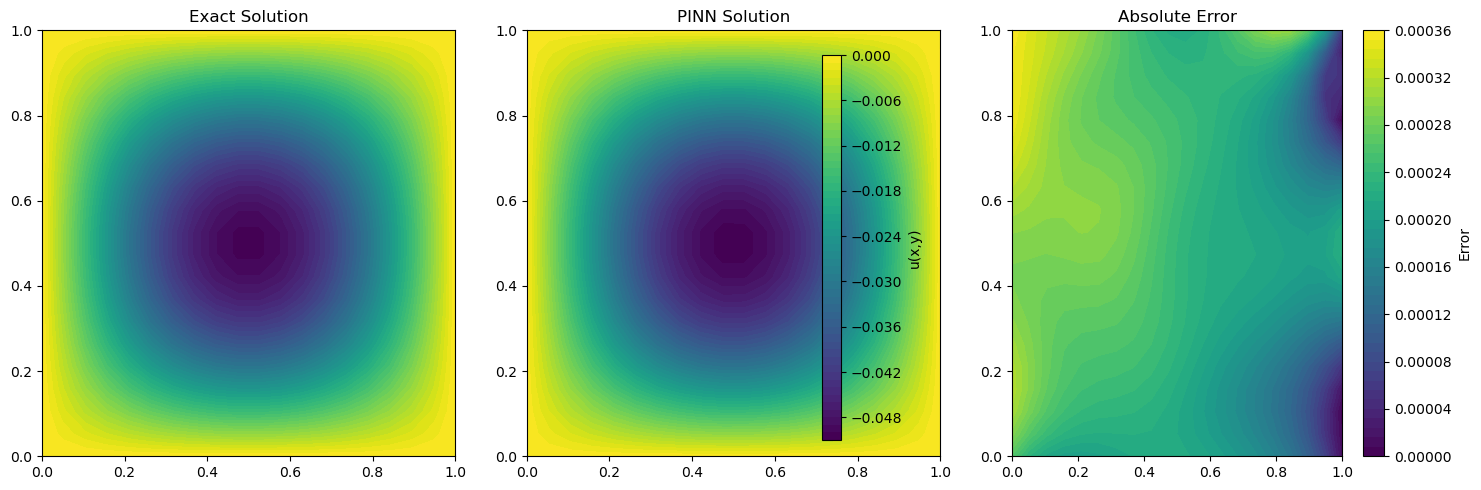


Solving with grid size 40x40
Epoch 0: Total Loss = 0.876850, PDE Loss = 0.254927, BC Loss = 0.006219
Epoch 1000: Total Loss = 0.003206, PDE Loss = 0.001871, BC Loss = 0.000013
Epoch 2000: Total Loss = 0.006581, PDE Loss = 0.001096, BC Loss = 0.000055
Epoch 3000: Total Loss = 0.000688, PDE Loss = 0.000461, BC Loss = 0.000002
Epoch 4000: Total Loss = 0.000199, PDE Loss = 0.000165, BC Loss = 0.000000
Epoch 5000: Total Loss = 0.000405, PDE Loss = 0.000074, BC Loss = 0.000003
Epoch 6000: Total Loss = 0.000059, PDE Loss = 0.000054, BC Loss = 0.000000
Epoch 7000: Total Loss = 0.000049, PDE Loss = 0.000045, BC Loss = 0.000000
Epoch 8000: Total Loss = 0.000042, PDE Loss = 0.000037, BC Loss = 0.000000
Epoch 9000: Total Loss = 0.000715, PDE Loss = 0.000111, BC Loss = 0.000006
Epoch 10000: Total Loss = 0.000108, PDE Loss = 0.000033, BC Loss = 0.000001
Epoch 11000: Total Loss = 0.000700, PDE Loss = 0.000044, BC Loss = 0.000007
Epoch 12000: Total Loss = 0.000042, PDE Loss = 0.000025, BC Loss = 0.00

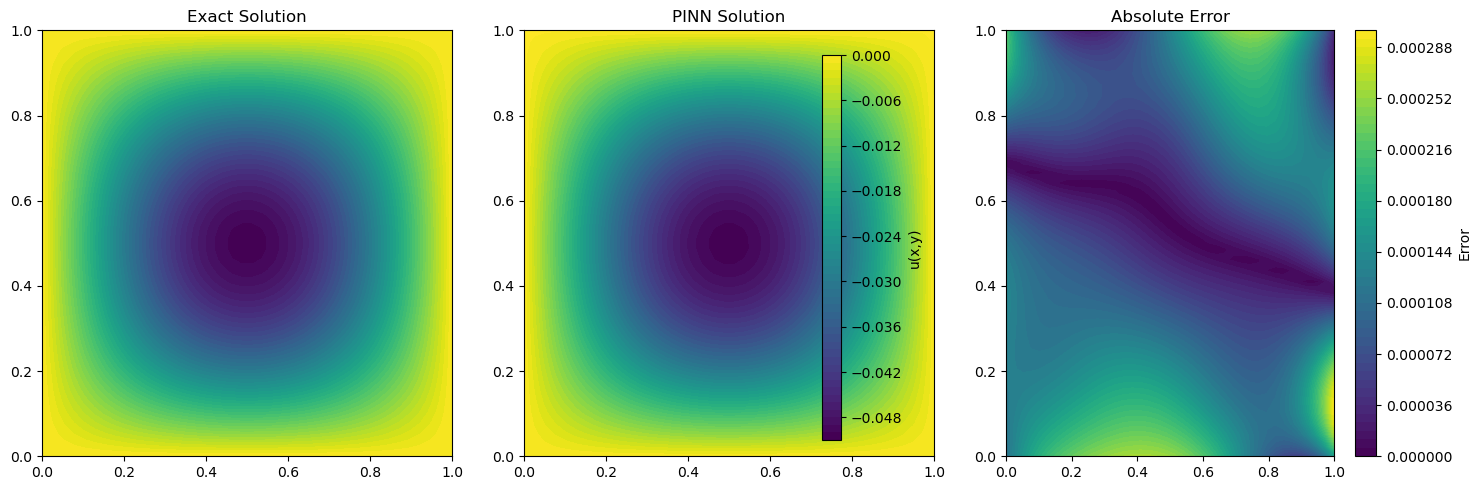

In [22]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam
import time
from matplotlib.colors import Normalize

class PINN(nn.Module):
    def __init__(self, hidden_layers=[64, 64, 64, 32]):
        super().__init__()
        layers = []
        input_dim = 2
        
        # Deeper network with larger capacity
        for h in hidden_layers:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.Tanh())
            input_dim = h
            
        layers.append(nn.Linear(input_dim, 1))
        
        self.network = nn.Sequential(*layers)
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.zeros_(m.bias)
    
    def forward(self, x, y):
        xy = torch.cat([x, y], dim=1)
        return self.network(xy)
    
    def compute_loss(self, x_interior, y_interior, x_boundary, y_boundary, lambda_bc=100.0):
        """
        Compute the loss based only on the PDE and boundary conditions
        without using the exact solution
        """
        # Interior points
        x_interior.requires_grad_(True)
        y_interior.requires_grad_(True)
        
        u = self.forward(x_interior, y_interior)
        
        # Compute derivatives for Laplacian
        du_dx = torch.autograd.grad(u, x_interior, grad_outputs=torch.ones_like(u),
                                  create_graph=True)[0]
        du_dy = torch.autograd.grad(u, y_interior, grad_outputs=torch.ones_like(u),
                                  create_graph=True)[0]
        
        d2u_dx2 = torch.autograd.grad(du_dx, x_interior, grad_outputs=torch.ones_like(du_dx),
                                    create_graph=True)[0]
        d2u_dy2 = torch.autograd.grad(du_dy, y_interior, grad_outputs=torch.ones_like(du_dy),
                                    create_graph=True)[0]
        
        # PDE residual: ∇²u = sin(πx)sin(πy)
        laplacian = d2u_dx2 + d2u_dy2
        f = torch.sin(np.pi * x_interior) * torch.sin(np.pi * y_interior)
        pde_loss = torch.mean((laplacian - f) ** 2)
        
        # Boundary conditions: u = 0 on all boundaries
        u_boundary = self.forward(x_boundary, y_boundary)
        bc_loss = torch.mean(u_boundary ** 2)
        
        # Total loss with weighted boundary conditions
        total_loss = pde_loss + lambda_bc * bc_loss
        
        return total_loss, pde_loss, bc_loss

def generate_training_data(n_points, n_boundary=100):
    """Generate training data with more points near boundaries"""
    # Interior points
    x = torch.linspace(0, 1, n_points)
    y = torch.linspace(0, 1, n_points)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    x_interior = X.reshape(-1, 1)
    y_interior = Y.reshape(-1, 1)
    
    # Boundary points with higher density
    t = torch.linspace(0, 1, n_boundary)
    x_boundary = torch.cat([torch.zeros(n_boundary), torch.ones(n_boundary),
                          t, t])
    y_boundary = torch.cat([t, t,
                          torch.zeros(n_boundary), torch.ones(n_boundary)])
    
    return x_interior, y_interior, x_boundary.reshape(-1, 1), y_boundary.reshape(-1, 1)

def train_pinn(model, x_interior, y_interior, x_boundary, y_boundary, max_epochs=20000):
    """Train the PINN with adaptive learning rate"""
    optimizer = Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
                                                         patience=500, factor=0.5, 
                                                         verbose=True, min_lr=1e-5)
    
    best_loss = float('inf')
    patience = 2000
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(max_epochs):
        optimizer.zero_grad()
        loss, pde_loss, bc_loss = model.compute_loss(x_interior, y_interior, 
                                                    x_boundary, y_boundary)
        loss.backward()
        optimizer.step()
        
        scheduler.step(loss)
        
        # Save best model
        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
            
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}: Total Loss = {loss.item():.6f}, "
                  f"PDE Loss = {pde_loss.item():.6f}, "
                  f"BC Loss = {bc_loss.item():.6f}")
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model

def evaluate_accuracy(u_pred, u_exact):
    """Compute various error metrics"""
    error = np.abs(u_pred - u_exact)
    l2_error = np.sqrt(np.mean((u_pred - u_exact)**2))
    max_error = np.max(error)
    mean_error = np.mean(error)
    
    return {
        'L2': l2_error,
        'Max': max_error,
        'Mean': mean_error
    }

def main():
    grid_sizes = [20, 40]
    
    for n_points in grid_sizes:
        print(f"\nSolving with grid size {n_points}x{n_points}")
        
        # Generate training data
        x_interior, y_interior, x_boundary, y_boundary = generate_training_data(n_points)
        
        # Initialize and train PINN
        model = PINN()
        trained_model = train_pinn(model, x_interior, y_interior, x_boundary, y_boundary)
        
        # Generate evaluation grid
        x = np.linspace(0, 1, n_points)
        y = np.linspace(0, 1, n_points)
        X, Y = np.meshgrid(x, y)
        
        # Compute solutions
        x_eval = torch.from_numpy(X.flatten()).float().reshape(-1, 1)
        y_eval = torch.from_numpy(Y.flatten()).float().reshape(-1, 1)
        
        with torch.no_grad():
            u_pinn = trained_model(x_eval, y_eval).numpy().reshape(n_points, n_points)
        
        # Exact solution for comparison
        u_exact = -1/(2*np.pi**2) * np.sin(np.pi*X) * np.sin(np.pi*Y)
        
        # Compute errors
        errors = evaluate_accuracy(u_pinn, u_exact)
        print("\nError Metrics:")
        print(f"L2 Error: {errors['L2']:.2e}")
        print(f"Max Error: {errors['Max']:.2e}")
        print(f"Mean Error: {errors['Mean']:.2e}")
        
        # Plotting
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        
        vmin = min(u_exact.min(), u_pinn.min())
        vmax = max(u_exact.max(), u_pinn.max())
        norm = Normalize(vmin=vmin, vmax=vmax)
        
        im1 = ax1.contourf(X, Y, u_exact, levels=50, norm=norm)
        ax1.set_title('Exact Solution')
        
        im2 = ax2.contourf(X, Y, u_pinn, levels=50, norm=norm)
        ax2.set_title('PINN Solution')
        
        error = np.abs(u_exact - u_pinn)
        im3 = ax3.contourf(X, Y, error, levels=50)
        ax3.set_title('Absolute Error')
        
        fig.colorbar(im1, ax=[ax1, ax2], label='u(x,y)')
        fig.colorbar(im3, ax=ax3, label='Error')
        
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    main()